# IMPORTS

In [8]:
import os
import random
import time
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                      Flatten, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# SETUP PATHS

In [9]:
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Verify paths exist
print(f"Dataset path exists: {os.path.exists(dataset_path)}")
print(f"Training directory exists: {os.path.exists(train_dir)}")
print(f"Testing directory exists: {os.path.exists(test_dir)}")

Dataset path exists: True
Training directory exists: True
Testing directory exists: True


In [10]:
if os.path.exists(train_dir):
    classes = sorted(os.listdir(train_dir))
    print(f"\nClasses found: {classes}")
    
    print("\nImages per class:")
    for cls in classes:
        class_path = os.path.join(train_dir, cls)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) 
                            if f.endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  {cls}: {num_images} images")


Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']

Images per class:
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images


# DATA GENERATORS

In [11]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

# Only rescaling for validation (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Testing samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training samples: 4857
Validation samples: 855
Testing samples: 1311
Number of classes: 4
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# VISUALIZATION FUNCTIONS

In [12]:
def plot_class_distribution(generator, title="Class Distribution"):
    """Plot the distribution of classes in the dataset"""
    class_counts = {}
    class_names = list(generator.class_indices.keys())
    
    for class_name in class_names:
        class_counts[class_name] = list(generator.classes).count(
            generator.class_indices[class_name])
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(),
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'],
                   edgecolor='black', linewidth=1.5)
    
    plt.xlabel('Tumor Type', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

In [13]:
def display_samples_per_class(generator, samples_per_class=4):
    """Display sample images from each class"""
    class_indices = generator.class_indices
    class_names = list(class_indices.keys())
    
    fig, axes = plt.subplots(len(class_names), samples_per_class,
                             figsize=(12, 3*len(class_names)))
    fig.suptitle("Sample Images per Class", fontsize=16, fontweight='bold')
    
    for class_idx, class_name in enumerate(class_names):
        # Get images for this class
        class_images = [path for path in generator.filepaths
                       if class_name in path]
        
        # Sample random images
        selected_images = random.sample(class_images,
                                       min(samples_per_class, len(class_images)))
        
        for img_idx, img_path in enumerate(selected_images):
            img = image.load_img(img_path, target_size=(128, 128))
            
            if len(class_names) == 1:
                ax = axes[img_idx]
            else:
                ax = axes[class_idx, img_idx]
            
            ax.imshow(img)
            if img_idx == 0:
                ax.set_ylabel(class_name, fontsize=12, fontweight='bold')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
def plot_augmentation_samples(generator, num_samples=4):
    """Visualize original vs augmented samples"""
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    fig.suptitle("Original vs Augmented Brain MRI Samples", 
                 fontsize=16, fontweight='bold')
    
    # Get random sample paths
    sample_paths = random.sample(generator.filepaths, num_samples)
    
    for i, img_path in enumerate(sample_paths):
        # Load original image
        original_img = image.load_img(img_path, target_size=(128, 128))
        x = image.img_to_array(original_img)
        x = np.expand_dims(x, axis=0)
        
        # Generate augmented image
        aug_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        aug_iter = aug_datagen.flow(x, batch_size=1)
        augmented_img = next(aug_iter)[0].astype('uint8')
        
        # Get class name from path
        class_name = img_path.split('/')[-2]
        
        # Plot original
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f"Original\n{class_name}", 
                             fontsize=11, fontweight='bold')
        axes[0, i].axis('off')
        
        # Plot augmented
        axes[1, i].imshow(augmented_img)
        axes[1, i].set_title("Augmented", fontsize=11)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# VISUALIZE DATA

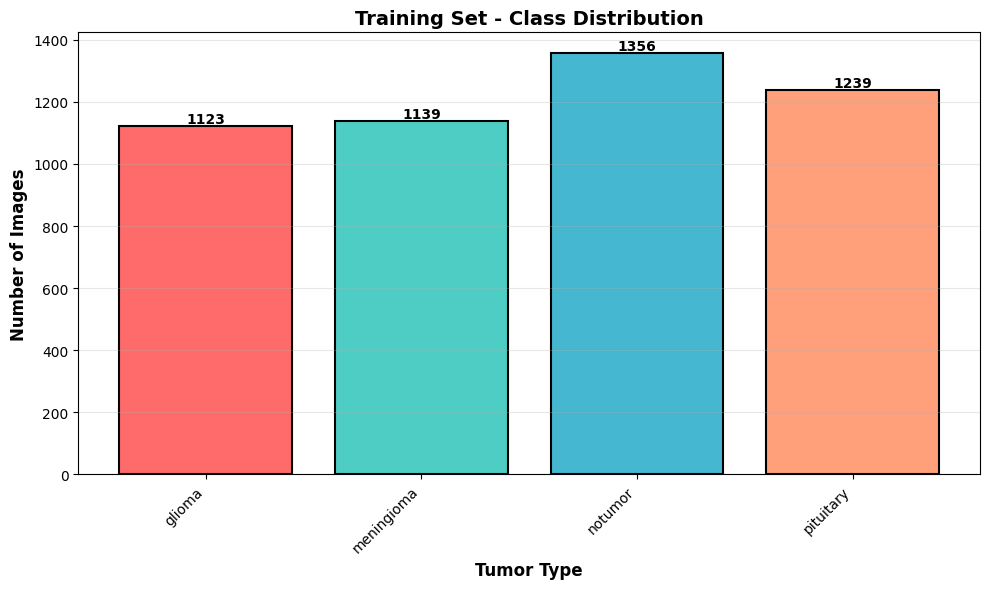

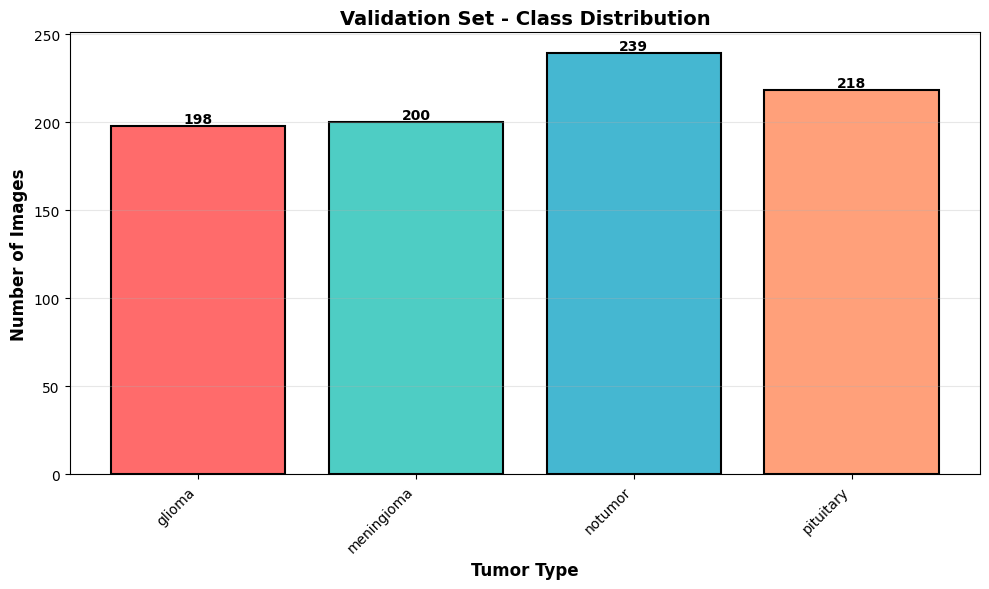

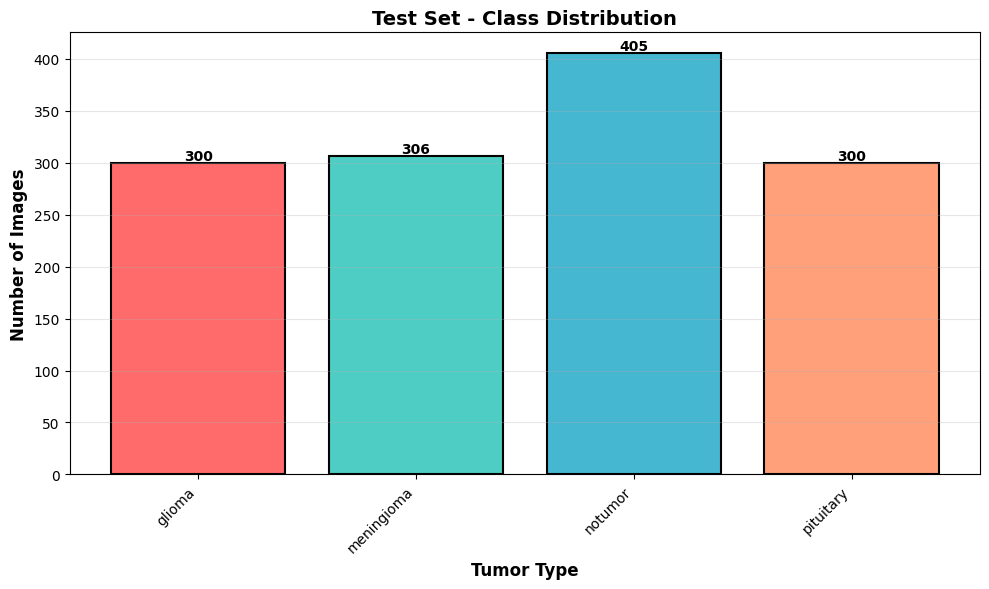

In [27]:
plot_class_distribution(train_generator, "Training Set - Class Distribution")
plot_class_distribution(val_generator, "Validation Set - Class Distribution")
plot_class_distribution(test_generator, "Test Set - Class Distribution")

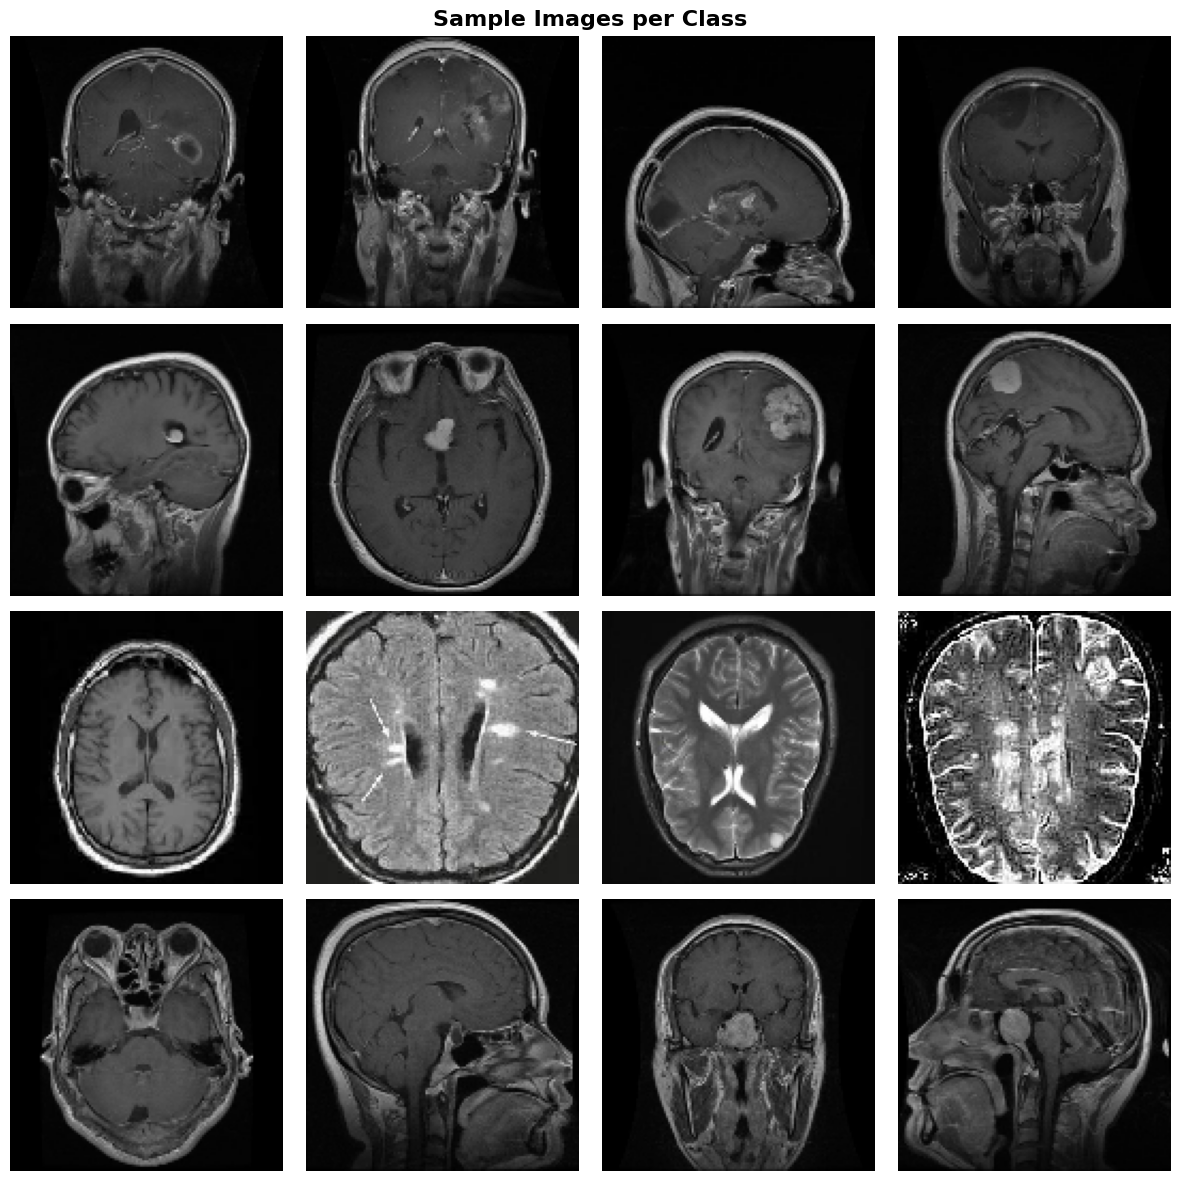

In [28]:
# Sample images
display_samples_per_class(train_generator, samples_per_class=4)

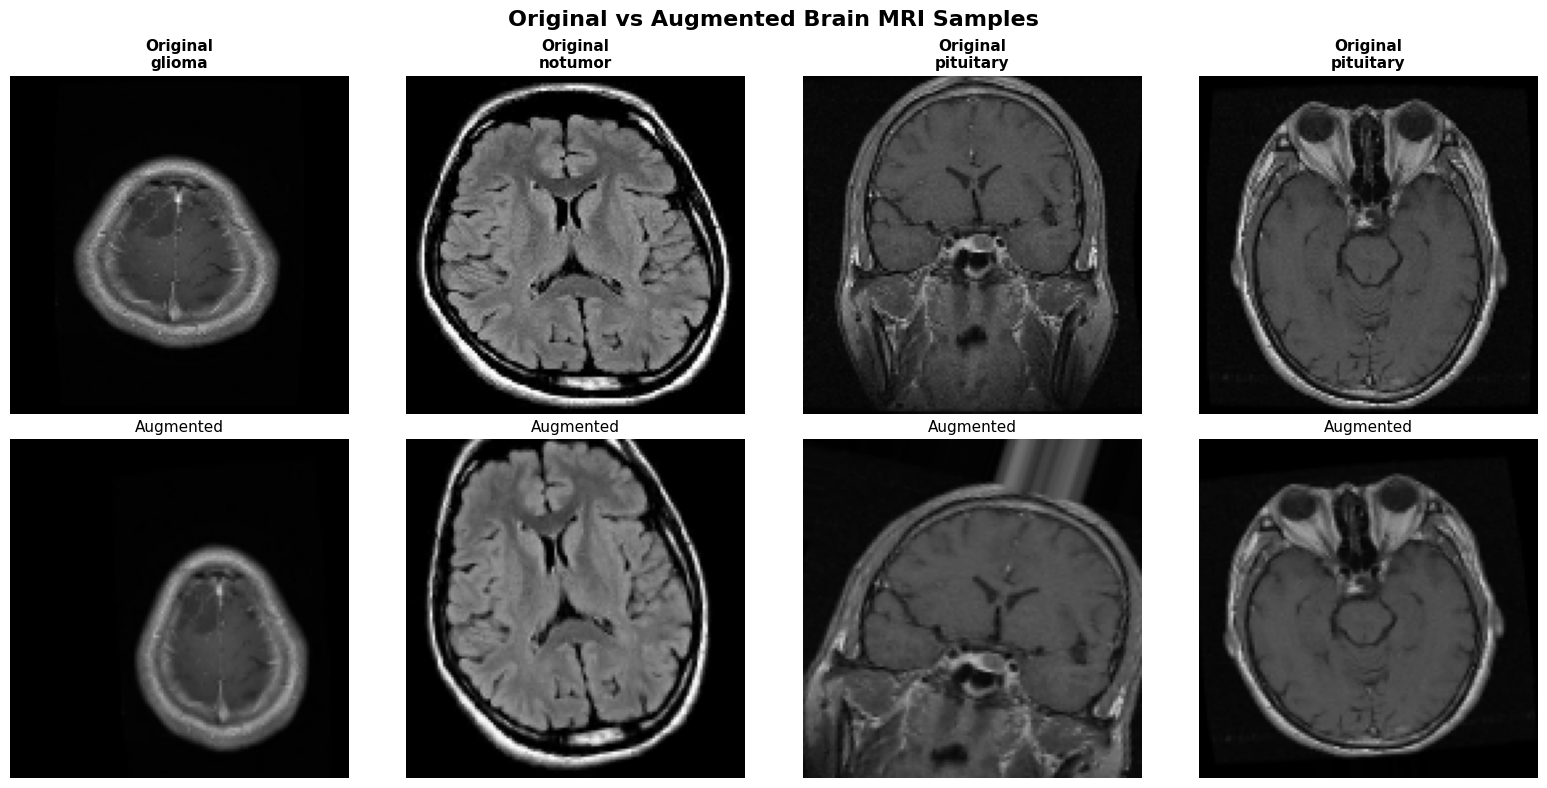

In [26]:
# Augmentation visualization
plot_augmentation_samples(train_generator, num_samples=4)

# MODEL ARCHITECTURE

In [16]:
def create_cnn_model(filters=[64, 128, 256],
                     dropout_rate=0.5,
                     l2_reg=0.001,
                     dense_units=256,
                     input_shape=(128, 128, 3),
                     num_classes=4):
    """
    Create CNN model for brain tumor classification
    
    Args:
        filters: List of filter sizes for conv layers
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization coefficient
        dense_units: Number of units in dense layers
        input_shape: Input image shape
        num_classes: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    model = Sequential(name='BrainTumorCNN')
    
    # Conv Block 1
    model.add(Conv2D(filters[0], (3, 3), activation='relu',
                     input_shape=input_shape, padding='same',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.4))
    
    # Conv Block 2
    model.add(Conv2D(filters[1], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.6))
    
    # Conv Block 3
    model.add(Conv2D(filters[2], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.8))
    
    # Dense Layers
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units // 2, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# TRAINING FUNCTION

In [17]:
def train_and_evaluate(model, train_gen, val_gen,
                       learning_rate=0.001,
                       optimizer_type='adam',
                       epochs=50,
                       patience=10,
                       verbose=1):
    """
    Train model and return validation accuracy
    
    Args:
        model: Keras model to train
        train_gen: Training data generator
        val_gen: Validation data generator
        learning_rate: Learning rate for optimizer
        optimizer_type: Type of optimizer ('adam', 'sgd', 'rmsprop')
        epochs: Maximum number of epochs
        patience: Early stopping patience
        verbose: Verbosity level
    
    Returns:
        history, best_val_acc, training_time, best_epoch
    """
    # Select optimizer
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    # Compile
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience // 2,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train
    start_time = time.time()
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, lr_scheduler],
        verbose=verbose
    )
    
    training_time = time.time() - start_time
    
    # Get best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Best validation accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")
    
    return history, best_val_acc, training_time, best_epoch

**EVALUATION FUNCTION**

In [18]:
def evaluate_model(model, test_gen, class_names, model_name="Model"):
    """
    Evaluate model on test set with detailed metrics
    
    Args:
        model: Trained Keras model
        test_gen: Test data generator
        class_names: List of class names
        model_name: Name for display
    
    Returns:
        Dictionary with evaluation results
    """
    
    # Predictions
    print("Generating predictions")
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    
    # Overall Metrics
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n Test Accuracy: {test_acc*100:.2f}%")
    print(f" Test Loss: {test_loss:.4f}")
    
    # Classification Report
    report = classification_report(y_true, y_pred_classes,
                                   target_names=class_names,
                                   digits=4)
    print(report)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Per-class accuracy
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        correct = cm[i, i]
        total = cm[i, :].sum()
        print(f"  {class_name:15s}: {class_acc*100:.2f}% ({correct}/{total})")
    
    return {
        'accuracy': test_acc,
        'loss': test_loss,
        'confusion_matrix': cm,
        'predictions': y_pred_classes,
        'probabilities': y_pred_probs,
        'true_labels': y_true
    }

**PLOTTING FUNCTIONS**

In [19]:
def plot_training_history(history, title="Training History"):
    """Plot training and validation accuracy/loss"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(epochs_range, acc, 'b-o', label='Training', linewidth=2, markersize=4)
    ax1.plot(epochs_range, val_acc, 'r-s', label='Validation', linewidth=2, markersize=4)
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = max(val_acc)
    ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label='Best')
    ax1.plot(best_epoch, best_val_acc, 'g*', markersize=15)
    ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(epochs_range, loss, 'b-o', label='Training', linewidth=2, markersize=4)
    ax2.plot(epochs_range, val_loss, 'r-s', label='Validation', linewidth=2, markersize=4)
    ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Model Loss', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n Best Validation Accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """Plot confusion matrix heatmap"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

**CREATE AND TRAIN MODEL**

In [20]:
baseline_model = create_cnn_model(
    filters=[64, 128, 256],
    dropout_rate=0.5,
    l2_reg=0.001,
    dense_units=256
)

baseline_model.summary()

# Train the model
baseline_history, baseline_val_acc, baseline_time, baseline_epoch = train_and_evaluate(
    baseline_model,
    train_generator,
    val_generator,
    learning_rate=0.001,
    optimizer_type='adam',
    epochs=50,
    patience=10,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765918594.444146      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "BrainTumorCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,185,028 (65.56 MB)

 Trainable params: 17,183,364 (65.55 MB)

 Non-trainable params: 1,664 (6.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1765918600.503389     214 service.cc:148] XLA service 0x7875f8016d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765918600.504194     214 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765918601.141043     214 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/152 ━━━━━━━━━━━━━━━━━━━━ 28:59 12s/step - accuracy: 0.2500 - loss: 3.1100

I0000 00:00:1765918607.986759     214 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 363ms/step - accuracy: 0.4917 - loss: 2.8591 - val_accuracy: 0.3146 - val_loss: 4.7779 - learning_rate: 0.0010
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 176ms/step - accuracy: 0.6100 - loss: 2.5710 - val_accuracy: 0.4433 - val_loss: 3.0030 - learning_rate: 0.0010
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.6451 - loss: 2.3588 - val_accuracy: 0.5064 - val_loss: 2.4973 - learning_rate: 0.0010
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 173ms/step - accuracy: 0.6918 - loss: 2.0492 - val_accuracy: 0.4433 - val_loss: 2.9112 - learning_rate: 0.0010
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 174ms/step - accuracy: 0.7052 - loss: 1.7883 - val_accuracy: 0.5205 - val_loss: 2.3668 - learning_rate: 0.0010
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.7210 - loss: 1.6520 - val_accuracy: 0.2854 - val_loss: 4.9817 - learning_rate: 0.0010
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.7300 - loss:

**PLOT TRAINING RESULTS**

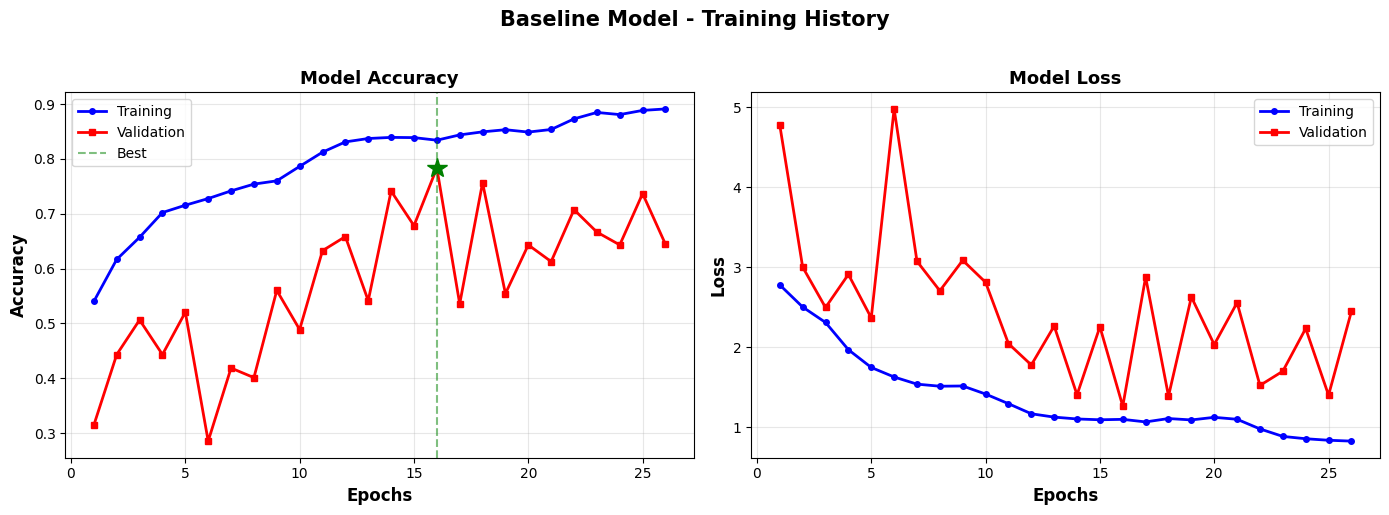


 Best Validation Accuracy: 78.36% at epoch 16
Generating predictions

✓ Test Accuracy: 77.65%
✓ Test Loss: 1.2407
              precision    recall  f1-score   support

      glioma     0.9276    0.6833    0.7869       300
  meningioma     0.6774    0.4118    0.5122       306
     notumor     0.7920    0.9778    0.8751       405
   pituitary     0.7203    0.9700    0.8267       300

    accuracy                         0.7765      1311
   macro avg     0.7793    0.7607    0.7502      1311
weighted avg     0.7799    0.7765    0.7592      1311

  glioma         : 68.33% (205/300)
  meningioma     : 41.18% (126/306)
  notumor        : 97.78% (396/405)
  pituitary      : 97.00% (291/300)


In [23]:
plot_training_history(baseline_history, "Baseline Model - Training History")

# EVALUATE ON TEST SET
class_names = list(train_generator.class_indices.keys())
baseline_results = evaluate_model(baseline_model, test_generator, 
                                  class_names, "Baseline Model")

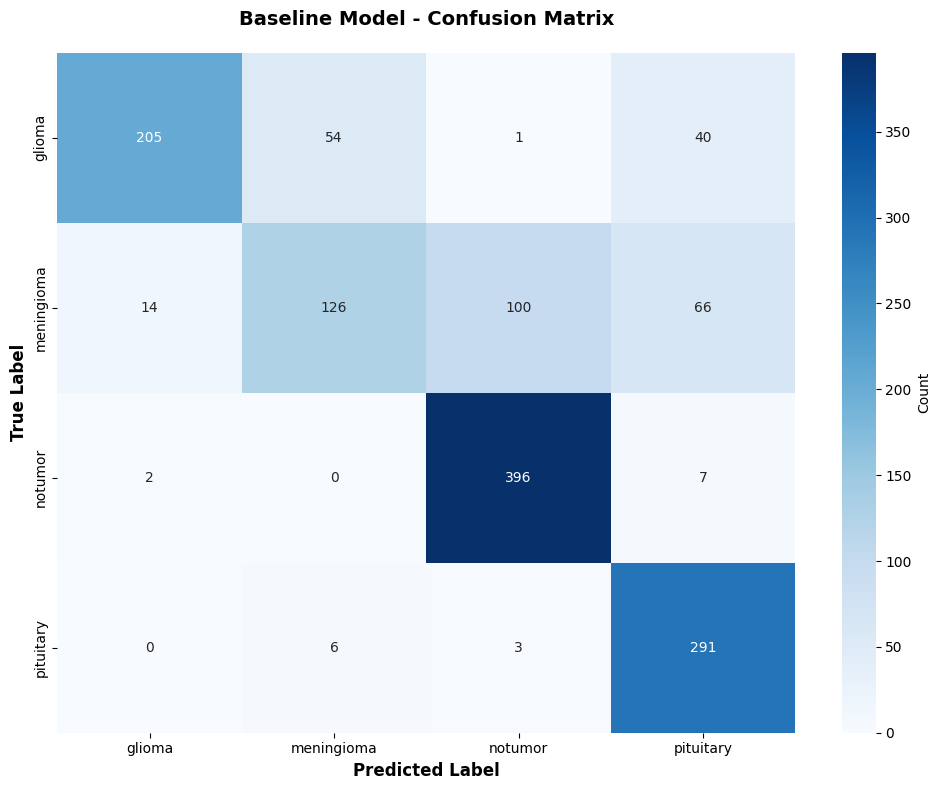

In [24]:
# Plot confusion matrix
plot_confusion_matrix(baseline_results['confusion_matrix'], 
                     class_names, "Baseline Model - Confusion Matrix")

# SAVE MODEL

In [22]:
# Save in Kaggle's working directory
baseline_model.save('/kaggle/working/baseline_model.keras')
print(" Model saved as: /kaggle/working/baseline_model.keras")

# Save training history
history_dict = {
    'accuracy': baseline_history.history['accuracy'],
    'val_accuracy': baseline_history.history['val_accuracy'],
    'loss': baseline_history.history['loss'],
    'val_loss': baseline_history.history['val_loss']
}

with open('/kaggle/working/training_history.json', 'w') as f:
    json.dump(history_dict, f)
print(" Training history saved as: /kaggle/working/training_history.json")

# Save results summary
results_summary = {
    'test_accuracy': float(baseline_results['accuracy']),
    'test_loss': float(baseline_results['loss']),
    'best_val_accuracy': float(baseline_val_acc),
    'best_epoch': int(baseline_epoch),
    'training_time_seconds': float(baseline_time),
    'class_names': class_names
}

with open('/kaggle/working/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print(" Results summary saved as: /kaggle/working/results_summary.json")

print(f" Best Validation Accuracy: {baseline_val_acc*100:.2f}%")
print(f" Test Accuracy: {baseline_results['accuracy']*100:.2f}%")
print(f" Training Time: {baseline_time:.2f} seconds")

 Model saved as: /kaggle/working/baseline_model.keras
 Training history saved as: /kaggle/working/training_history.json
 Results summary saved as: /kaggle/working/results_summary.json
 Best Validation Accuracy: 78.36%
 Test Accuracy: 77.65%
 Training Time: 747.44 seconds
